In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
!apt-get remove swig
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig

!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'swig' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 1367 kB of archives.
After this operation, 5618 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian stretch/main amd64 swig3.0 amd64 3.0.10-1.1 [1367 kB]
Fetched 1367 kB in 0s (12.0 MB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package swig3.0.
(Reading database ... 35518 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.1_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.1) ...
Setting up sw

  Stored in directory: /tmp/.cache/pip/wheels/12/52/83/d2d66a840968025d072ddb1cd776fdc5eb5e337e1cc887bc3f
Successfully built smac
    100% |████████████████████████████████| 3.4MB 8.1MB/s eta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/89/fb/f5/2f04d19502c1ad8e0706f925ff824de8d5628349c642599f24
Successfully built auto-sklearn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
all_data = pd.read_csv('../input/train_V2.csv')

In [7]:
all_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [8]:
all_data["_Kill_headshot_Ratio"] = all_data["kills"]/all_data["headshotKills"]
all_data['_killStreak_Kill_ratio'] = all_data['killStreaks']/all_data['kills']
all_data['_totalDistance'] = 0.25*all_data['rideDistance'] + all_data["walkDistance"] + all_data["swimDistance"]
all_data['_killPlace_MaxPlace_Ratio'] = all_data['killPlace'] / all_data['maxPlace']
all_data['_totalDistance_weaponsAcq_Ratio'] = all_data['_totalDistance'] / all_data['weaponsAcquired']
all_data['_walkDistance_heals_Ratio'] = all_data['walkDistance'] / all_data['heals']
all_data['_walkDistance_kills_Ratio'] = all_data['walkDistance'] / all_data['kills']
all_data['_kills_walkDistance_Ratio'] = all_data['kills'] / all_data['walkDistance']
all_data['_totalDistancePerDuration'] =  all_data["_totalDistance"]/all_data["matchDuration"]
all_data['_killPlace_kills_Ratio'] = all_data['killPlace']/all_data['kills']
all_data['_walkDistancePerDuration'] =  all_data["walkDistance"]/all_data["matchDuration"]
all_data['walkDistancePerc'] = all_data.groupby('matchId')['walkDistance'].rank(pct=True).values
all_data['killPerc'] = all_data.groupby('matchId')['kills'].rank(pct=True).values
all_data['killPlacePerc'] = all_data.groupby('matchId')['killPlace'].rank(pct=True).values
all_data['weaponsAcquired'] = all_data.groupby('matchId')['weaponsAcquired'].rank(pct=True).values
all_data['_walkDistance_kills_Ratio2'] = all_data['walkDistancePerc'] / all_data['killPerc']
all_data['_kill_kills_Ratio2'] = all_data['killPerc']/all_data['walkDistancePerc']
all_data['_killPlace_walkDistance_Ratio2'] = all_data['walkDistancePerc']/all_data['killPlacePerc']
all_data['_killPlace_kills_Ratio2'] = all_data['killPlacePerc']/all_data['killPerc']
all_data['_totalDistance'] = all_data.groupby('matchId')['_totalDistance'].rank(pct=True).values
all_data['_walkDistance_kills_Ratio3'] = all_data['walkDistancePerc'] / all_data['kills']
all_data['_walkDistance_kills_Ratio4'] = all_data['kills'] / all_data['walkDistancePerc']
all_data['_walkDistance_kills_Ratio5'] = all_data['killPerc'] / all_data['walkDistance']
all_data['_walkDistance_kills_Ratio6'] = all_data['walkDistance'] / all_data['killPerc']

all_data[all_data == np.Inf] = np.NaN
all_data[all_data == np.NINF] = np.NaN
all_data.fillna(0, inplace=True)

In [10]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [11]:
data = reduce_mem_usage(all_data)
del all_data

Memory usage of dataframe is 1730.31 MB
Memory usage after optimization is: 483.47 MB
Decreased by 72.1%


In [29]:
plt.rcParams['figure.figsize']=(20,10)

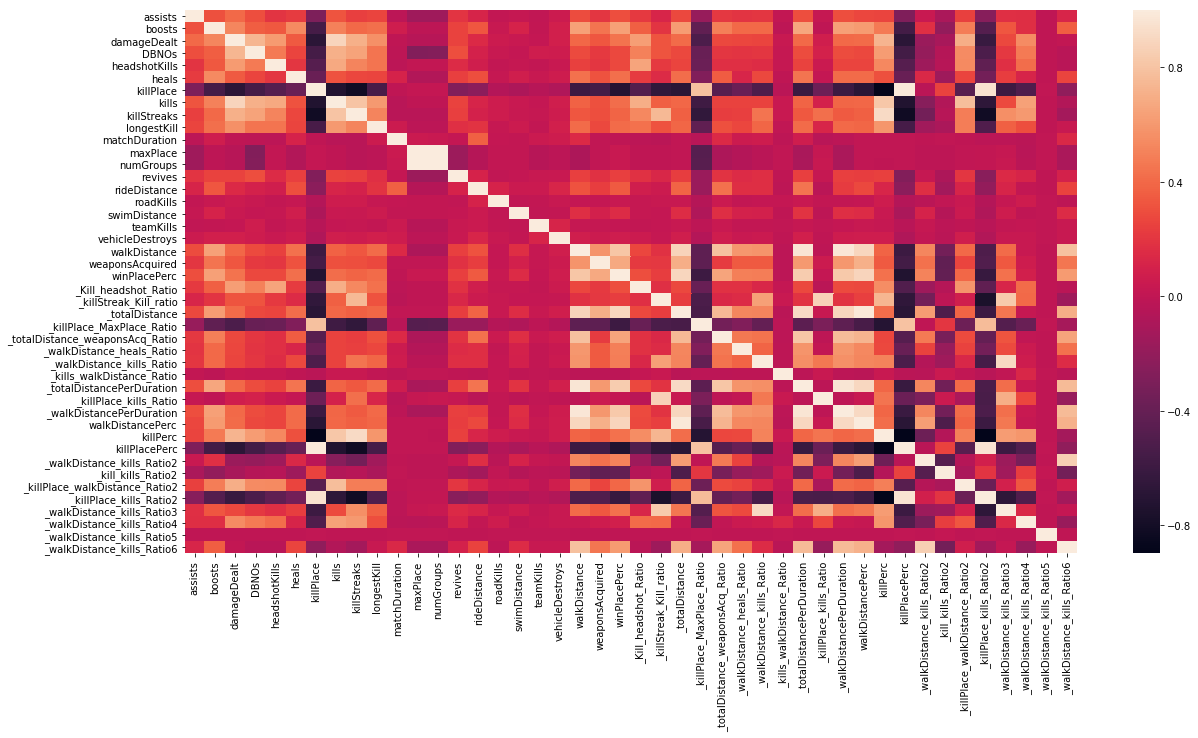

In [30]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)

In [31]:
#because IDs are not useful for predictions
columnsToBeRemoved = ['Id', 'groupId', 'matchId']

In [34]:
# Elo-like columns correlation
eloLikeColumns = ['killPoints', 'rankPoints', 'winPoints']
#elo_corr = data[eloLikeColumns].corr()
#sns.heatmap(elo_corr, 
#            xticklabels=elo_corr.columns.values,
 #         yticklabels=elo_corr.columns.values)

In [21]:
#Decided to remove them
columnsToBeRemoved = columnsToBeRemoved + eloLikeColumns

In [22]:
def removeColumns(data):
    return data.drop(columns = columnsToBeRemoved)

In [35]:
from sklearn.preprocessing import LabelBinarizer

class MatchTypeEncoder:
    def __init__(self):
        self._columnName = 'matchType'
        self._encoder =  LabelBinarizer()
    
    def fit(self, data):
        column = data[[self._columnName]]
        self._encoder.fit(column)
    
    def transform(self, data):
        column = data[[self._columnName]]
        return self._encoder.transform(column)

In [42]:
from sklearn.preprocessing import MinMaxScaler

class NumericScaler:
    def __init__(self):
        self._columns = ['assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'maxPlace',
       'numGroups', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired']
        self._scaler = MinMaxScaler()
        
    def fit(self, data):
        columns = data[self._columns]
        self._scaler.fit(columns)
        
    def transform(self, data):
        columns = data[self._columns]
        return self._scaler.transform(columns)

In [38]:
data = removeColumns(data)

KeyError: "['Id' 'groupId' 'matchId'] not found in axis"

In [39]:
categoricalEncoder = MatchTypeEncoder()
numericalScaler = NumericScaler()

In [27]:
categoricalEncoder.fit(data)
categoricalEncodedData = categoricalEncoder.transform(data)
categoricalEncodedData = pd.DataFrame(categoricalEncodedData, columns = data['matchType'].unique())

In [28]:
categoricalEncoder.fit(data)
categoricalEncodedData = categoricalEncoder.transform(data)
categoricalEncodedData = pd.DataFrame(categoricalEncodedData, columns = data['matchType'].unique())

In [44]:
numericalScaler.fit(data)
numericalScaledData = numericalScaler.transform(data)
numericalScaledData = pd.DataFrame(numericalScaledData, columns = numericalScaler._columns)

In [45]:
processedData = pd.concat([categoricalEncodedData, numericalScaledData, data['winPlacePerc']], axis = 1)

In [46]:
from sklearn.utils import resample
#processedData = resample(processedData, n_samples = int(processedData.shape[0] * 0.4), random_state = 666)

In [47]:
from sklearn.model_selection import train_test_split
X = processedData.drop(columns= ['winPlacePerc'])
y = processedData[['winPlacePerc']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 666, train_size = 0.6)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [48]:
del numericalScaledData
del categoricalEncodedData
del data
del processedData

In [49]:
X_train.shape

(2668179, 37)

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [53]:
try:
    from autosklearn.metrics import mean_absolute_error
    from autosklearn.regression import AutoSklearnRegressor
except:
    import time
    time.sleep(5)
    
    from autosklearn.metrics import mean_absolute_error
    from autosklearn.regression import AutoSklearnRegressor

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AutoSKlarnRegressor czeka na plik i dlatego try bo nie pojdzie jak zrobi sie 
calego Commita na wszystko


In [51]:
!wc -l ../input/train_V2.csv

4446967 ../input/train_V2.csv


In [56]:
automl = AutoSklearnRegressor(
        time_left_for_this_task = 60 * 10,
        per_run_time_limit = 60 * 2,
        tmp_folder = '/tmp/autosklearn_cv17_tmp',
        output_folder = '/tmp/autosklearn_cv17_out',
        delete_tmp_folder_after_terminate = True,
        ml_memory_limit = 1024 * 10,
        include_estimators=["random_forest", 'adaboost'],
        exclude_estimators=None,
        resampling_strategy = 'cv',
        resampling_strategy_arguments = {'folds': 5},
        n_jobs = 1
    )

time_left .. czas jak dlugo bedzie robic
jak w include_estimators nie poda sie to probuje wszystkie
resampling - cross walidacja - 20% testowy, 80 treningowy, 
hyperparatery z testowego sprawdzamy i sobie czy ma sens
5 walidacji {'folds': 5}, n_jobs - ile procesorow


In [57]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [58]:
automl.fit(X_train_copy, y_train_copy, dataset_name='PUBG', metric = mean_absolute_error)
automl.refit(X_train.copy(), y_train.copy())

print(automl.show_models())

predictions = automl.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("Mean absolute error", mean_absolute_error(y_test, predictions))

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)


[WARNING] [2019-04-11 17:40:21,038:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:21,181:AutoMLSMBO(1)::PUBG] Could not find meta-data directory /opt/conda/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_absolute_error_regression_dense
[WARNING] [2019-04-11 17:40:21,223:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:23,242:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:25,261:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:27,280:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:29,298:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:31,318:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:40:33,3

[WARNING] [2019-04-11 17:42:46,625:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:42:48,644:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:42:50,663:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:42:52,681:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:42:54,701:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:42:56,720:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:42:58,738:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:43:00,757:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:43:02,775:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] 

[WARNING] [2019-04-11 17:45:18,039:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:20,058:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:22,077:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:24,097:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:26,117:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:28,147:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:30,166:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:32,184:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:45:34,203:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] 

[WARNING] [2019-04-11 17:47:49,503:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:47:51,521:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:47:53,540:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:47:55,559:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:47:57,577:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:47:59,595:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:48:01,612:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:48:03,630:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] [2019-04-11 17:48:05,650:EnsembleBuilder(1):PUBG] No models better than random - using Dummy Score!
[WARNING] 

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/lib/python3.6/site-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)


[(1.000000, MyDummyRegressor(configuration=1, init_params=None, random_state=None)),
]
Mean absolute error 0.2679349121895915


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
